In [4]:
import numpy as np
import pandas as pd
import random

import seaborn as sns
import matplotlib.pyplot as plt

import glob


The aim here is to select the subset of sgRNAs to be used in a batch rescreen. The main emphasis is on  a galvanotaxis sublibrary, but based on the pricing, I can likely include synthesis of a differentiation and ECM pool -> where I used pool specific primers to amplify each of the desired subsets. 

Following same assembly as Sanson et al. 2018:
5′-[Forward Primer]CGTCTCACACCG[sgRNA, 20 nt]GTTTCGAGACG[Reverse Primer]

Primer Set: Forward Primer, 5′ – 3′; Reverse Primer, 5′ – 3′

Galvanotaxis; \
AGGCACTTGCTCGTACGACG; ATGTGGGCCCGGCACCTTAA (rev complement: TTAAGGTGCCGGGCCCACAT) \
2660 sgRNA + 250 control sgRNA; 1079 genes \
'AGGCACTTGCTCGTACGACG' + 'CGTCTCACACCG' + 20bp sgRNA + 'GTTTCGAGACG' + 'TTAAGGTGCCGGGCCCACAT' \

ECM; \
GTGTAACCCGTAGGGCACCT; GTCGAGAGCAGTCCTTCGAC (rev complement: GTCGAAGGACTGCTCTCGAC) \
1287 sgRNA + 250 control sgRNA, 487 genes \
'GTGTAACCCGTAGGGCACCT' + 'CGTCTCACACCG' + 20bp sgRNA + 'GTTTCGAGACG' + 'GTCGAAGGACTGCTCTCGAC' \
 
Differentiation; \
CAGCGCCAATGGGCTTTCGA; AGCCGCTTAAGAGCCTGTCG (rev complement: CGACAGGCTCTTAAGCGGCT) \
1271 sgRNA + 250 control sgRNA, 614 genes \
'CAGCGCCAATGGGCTTTCGA' + 'CGTCTCACACCG' + 20bp sgRNA + 'GTTTCGAGACG' + 'CGACAGGCTCTTAAGCGGCT' \
 

4; CTACAGGTACCGGTCCTGAG; GTACCTAGCGTGACGATCCG


In [441]:
252*3 + 2660 + 1287 + 1271

5974

In [442]:
# if I include 3 sgRNA per gene
252*3 +  1079*3 + 487*3 + 614*3

7296

In [443]:
files = glob.glob('../../data/screen_summary/*pvalue*.csv')
df = pd.read_csv(files[0])
df = df[['exp', 'gene', 'log2fold_diff_mean', 'pvalue']]
df.head()

,exp,gene,log2fold_diff_mean,pvalue
0,differentiation,A1BG,0.034291,0.893455
1,differentiation,A1CF,0.069892,0.626706
2,differentiation,A2M,0.034423,0.896435
3,differentiation,A2ML1,-0.026629,0.232870
4,differentiation,A3GALT2,0.177439,0.018361


In [444]:
df.pvalue.min()

9.716166958532225e-08

In [445]:
# there are a number of high confidence hits that didn't get a pvalue assigned; 
# give them the lowest calculated pvalues
df = df.replace(np.nan, 9E-8)

In [446]:
from scipy.stats import rankdata
def fdr_(p_vals):
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1

    return fdr

In [447]:
df_fdr = pd.DataFrame()
for exp, d in df.groupby('exp'):
    fdr = fdr_(d.pvalue.values)
    d['fdr'] = fdr
    df_fdr = df_fdr.append(d, ignore_index = True)

In [448]:
df_fdr.head()

,exp,gene,log2fold_diff_mean,pvalue,fdr
0,ECM_all,A1BG,0.210615,0.229836,0.976454
1,ECM_all,A1CF,-0.129601,0.488840,0.981851
2,ECM_all,A2M,-0.051376,0.713830,0.994821
3,ECM_all,A2ML1,-0.051428,0.762401,0.998611
4,ECM_all,A3GALT2,0.143812,0.419690,0.984611


In [449]:
# df_fdr[df_fdr.exp == 'galvo'].sort_values(by = 'log2fold_diff_mean')[:50]

In [450]:
df_fdr[df_fdr.exp.str.contains('galvo')][df_fdr.gene == 'SDC2']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,exp,gene,log2fold_diff_mean,pvalue,fdr
157902,galvo,SDC2,-0.660670,0.029231,0.974289
178800,galvo_all,SDC2,-0.387398,0.018801,0.675080
199698,galvo_bestruns,SDC2,-0.225844,0.286576,1.000000
220596,galvo_topbestruns,SDC2,-0.482652,0.206436,1.000000


In [451]:
galvo_genes = df_fdr[df_fdr.exp.str.contains('galvo')][df_fdr.fdr<=0.7].gene.unique()
diff_genes = df_fdr[df_fdr.exp.str.contains('diff')][df_fdr.fdr<=0.05].gene.unique()
growth_genes = df_fdr[df_fdr.exp.str.contains('growth')][df_fdr.fdr<=0.05].gene.unique()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [452]:
print('galvo, ', len(galvo_genes))
print('differentiation, ', len(diff_genes))
print('growth, ', len(growth_genes))

galvo,  1399
differentiation,  1860
growth,  2189


In [453]:
# for g in diff_genes:
#     print(g)

In [454]:
# galvo_genes_diff = np.isin(galvo_genes,diff_genes)
# galvo_genes_noD = galvo_genes[~galvo_genes_diff]

# galvo_genes_growth = np.isin(galvo_genes_noD,growth_genes)
# galvo_genes_noD_noG = galvo_genes_noD[~galvo_genes_growth]

In [455]:
# for g in np.sort(galvo_genes_noD_noG):
#     print(g)


In [456]:
# for gene in np.sort(galvo_genes[~galvo_genes_diff]):
#     print(gene)

In [457]:
# len(np.sort(galvo_genes[galvo_genes_diff]))

In [458]:
# len(np.sort(galvo_genes[~galvo_genes_diff]))

In [459]:
# for sg, d in df[df.gene == 'CONTROL'].groupby(['exp', 'sgRNA']):
#     data_list = {'log2fold_diff_mean' : d.log2fold_diff_mean.mean(),
#                  'exp' : sg[0],
#                  'sgRNA' : sg[1],
#                  'gene' : 'CONTROL' + str(sgRNA_dict[sg[1]])}
#     df_sgRNA = df_sgRNA.append(data_list, ignore_index = True)
    


In [460]:
# df_sgRNA.to_csv('../../data/screen_summary/collated_screen_data_sgRNA_20210830.csv', index = False)

In [461]:
# df_sgRNA.exp.unique()

In [462]:
# df_fdr[df_fdr.exp.str.contains('galvo')][df_fdr.fdr<=0.7]

In [463]:
genes_galvo = []
count = 0
for g in np.sort(df_fdr[df_fdr.exp.str.contains('galvo')][df_fdr.fdr<=0.7].gene.unique()):
    if 'CONTROL' in g:
        continue
        
    # transcription/translation
    elif 'RPS' in g:
        continue
    elif 'RPL' in g:
        continue
    elif 'POL' in g:
        continue
    elif 'MED' in g:
        continue
    elif 'RPP' in g:
        continue
    elif 'TTF' in g:
        continue
    elif 'PRPF' in g:
        continue
    elif 'NOP' in g:
        continue
    elif 'NOL' in g:
        continue
    elif 'NOC' in g:
        continue
    elif 'NOB' in g:
        continue
    elif 'NRNP' in g:
        continue
    elif 'CNOT' in g:
        continue
    elif 'INTS' in g:
        continue
    elif 'RNASE' in g:
        continue
    elif 'RPR' in g:
        continue
    elif 'CPS' in g:
        continue   
    elif 'DNA' in g:
        continue
    elif 'SF3B' in g:
        continue
    elif 'SNRP' in g:
        continue
    elif 'UTP' in g:
        continue
        
    # histones, HMGB
    elif 'HMG' in g:
        continue
    elif 'HIST' in g:
        continue 
    elif 'SETD' in g:
        continue 
        
     
    # transcription factors
    elif 'ZNF' in g:
        continue
    elif 'ZC3H' in g:
        continue
    elif 'ZBTB' in g:
        continue    
    elif 'EIF' in g:
        continue
    elif 'DDX' in g:
        continue
    elif 'CEBDDX' in g:
        continue
    elif 'SPI1' in g:
        continue
    elif 'ZZEF1' in g:
        continue
    elif 'ZFP' in g:
        continue
    elif 'HOX' in g:
        continue
    elif 'MYB' in g:
        continue
    elif 'GTF2' in g:
        continue

     # oxidative phos
    elif 'NDUF' in g:
        continue
    elif 'ATP' in g:
        continue     
    elif 'COX' in g:
        continue
    elif 'TIMM' in g:
        continue
        
    count += 1
    genes_galvo = np.append(genes_galvo, g)
    
    
    
    print(g)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


A1CF
AARS
AARS2
AATF
ABCA8
ABCF1
ABHD12B
ABHD17A
ABO
ACACA
ACCS
ACIN1
ACOT7
ACTL6A
ACTR10
ACTR3
ACTR6
ACTR8
ADAT2
ADGRE2
ADH4
ADNP
ADRA1A
ADSL
ADSS
AGMO
AGPS
AGXT
AIMP2
AK2
AKAP10
AKAP13
AKAP17A
AKAP7
AKR1A1
AKR1B15
ALAD
ALG10B
ALG13
AMH
AMZ1
ANAPC2
ANAPC4
ANGPT1
ANKK1
ANKRD26
AP1G1
APBA3
APLF
APOA4
APOBEC3A
APOBEC4
ARF1
ARF5
ARHGAP12
ARHGAP30
ARHGAP42
ARHGAP45
ARHGDIB
ARHGEF10L
ARID4B
ARL2
ARNTL2
ASCC3
ASH1L
ASNA1
ATE1
ATIC
ATL2
AURKA
AURKB
B3GNT2
B4GALT1
B4GALT2
BABAM1
BACH1
BANF1
BANP
BAP1
BARD1
BCAS3
BCCIP
BCL2
BCS1L
BDP1
BEND4
BFAR
BIRC5
BLM
BRCA2
BRF1
BRI3
BROX
BTAF1
BTBD6
BTN3A3
BUB1B
BUD13
C10orf111
C10orf82
C11orf49
C14orf1
C14orf177
C14orf39
C15orf41
C15orf57
C16orf59
C16orf62
C17orf102
C17orf107
C17orf67
C18orf54
C18orf63
C18orf65
C19orf25
C19orf47
C1QA
C1QTNF5
C1orf27
C1orf87
C3orf38
C7orf26
C9orf50
C9orf57
CACYBP
CADM4
CALCOCO1
CALCRL
CAMKV
CAND1
CANX
CAP1
CAPZB
CARM1
CARS
CASP3
CASP9
CASQ1
CBFB
CCDC129
CCDC130
CCDC136
CCDC137
CCDC174
CCDC177
CCDC181
CCDC185
CCDC6
CCDC66
C

In [464]:
count

1072

In [465]:
# maybe add in:
# funcational RICTOR sgRNA; 
# TRAF6
# IFNAR2
# PKN1
# PRKCB
# IL4R
# HCAR2
# B3GAT3
# CHSY1
# CHST9
# CHST12
# genes_galvo = np.append(genes_galvo, )

In [317]:
# df_galvo = df_fdr[df_fdr.exp == 'galvo_bestruns']

In [318]:
# df_galvo_ = df_galvo[df_galvo.gene.isin(genes)]

In [319]:
# df_galvo__ = df_galvo_[['gene', 'log2fold_diff_mean']].sort_values('log2fold_diff_mean')

In [320]:
# df_galvo__.columns = ['GeneName', 'Rank']
# df_galvo__.to_csv('20211014_galvo_bestruns_tophits_fdr0_7.csv', sep= '\t', index=False)

In [321]:
# df_galvo__[df_galvo__.GeneName.str.contains('SRC')]

In [322]:
# len(df_galvo__)

In [323]:
# Now lets say I wanted to only look at the most effective sgRNAs
# In addition, and in order to still have multiple sgRNAs per gene, 
# lets include additional sgRNA from set B to have 3 sgRNA per gene.


In [466]:
# the current screen data
files = glob.glob('../../data/screen_summary/screen_log2fold_diffs_sgRNA_galvo_bestruns_20210826.csv')
df_galvo_sg = pd.read_csv(files[0])
# df = df[['exp', 'gene', 'log2fold_diff_mean', 'pvalue']]
df_galvo_sg = df_galvo_sg[df_galvo_sg.gene.isin(genes_galvo)]
df_galvo_sg.head()

# the sgRNAs from set B
df_dolc_setB = pd.read_csv('../../data/sanson_2018/Sanson_Dolc_CRISPRI_IDs_libB.csv')

In [467]:
# df_dolc = df_dolc_setB[df_dolc_setB.annotated_gene_symbol == 'SMARCAD1']
# print(df_dolc)
# print(df_dolc.loc[0].annotated_gene_symbol)

In [468]:
df_galvo_rescreen = pd.DataFrame()

count_galvo = 0
for g, d  in df_galvo_sg.groupby('gene'):
    d_ = d[abs(d.log2fold_diff_mean)>0.5]
    
    df_galvo_rescreen = df_galvo_rescreen.append(d_[['gene', 'sgRNA']], ignore_index = True)
    count_galvo += len(d_)


In [469]:
len(df_galvo_sg)

3212

In [470]:
count_galvo

1573

In [471]:
# repeat analysis using 'top only data' analysis values
files = glob.glob('../../data/screen_summary/screen_log2fold_diffs_sgRNA_galvo_20210826.csv')
df_galvo_sg = pd.read_csv(files[0])
# df = df[['exp', 'gene', 'log2fold_diff_mean', 'pvalue']]
df_galvo_sg = df_galvo_sg[df_galvo_sg.gene.isin(genes_galvo)]
df_galvo_sg.head()

,Unnamed: 0,gene,sgRNA,log2fold_diff_mean
9,9,CPA2,AAAAAACAGGATCAACCTCA,1.032126
26,26,ZEB2,AAAAACCTCGCCAAGAGTGT,0.392555
30,30,WFDC11,AAAAACTTACCAACCAGAAA,-0.840571
90,90,RTCB,AAAACTGTAGCAAAAACTCC,0.312655
97,97,ICE1,AAAAGAAACGCTACCCGGCG,0.108407


In [472]:
count_galvo = 0
for g, d  in df_galvo_sg.groupby('gene'):
    d_ = d[abs(d.log2fold_diff_mean)>0.5]
    df_galvo_rescreen = df_galvo_rescreen.append(d_[['gene', 'sgRNA']], ignore_index = True)
    count_galvo += len(d_)
#     print(g, d_)

In [473]:
len(df_galvo_sg)

3212

In [474]:
count_galvo

1596

In [475]:
df_galvo_rescreen = df_galvo_rescreen.drop_duplicates()

In [476]:
len(df_galvo_rescreen)

2161

In [477]:
# now look at the few extra genes I want to include
# files = glob.glob('../../data/screen_summary/screen_log2fold_diffs_sgRNA_galvo_bestruns_20210826.csv')
# df_galvo_sg = pd.read_csv(files[0])

# funcational RICTOR sgRNA; CGGGCTTACCTCGTACTCGG
# TRAF6 - AGCAGTGGCGTCCGCAGCTG, GGAGCCTTCGCCACCTTCGC
# IFNAR2, GACGCTTCTTCCCGGCGGGT, CTAAAGACGCTTCTTCCCGG
# PKN1, GCGCGACCCTCCCCGGCGCG, GAGGCGGGAGCCGAGCAGGC
# PRKCB, GGCCGCCAGAGCCGGCGCAG, AGCTGGGCGAGTGACAGCCC
# IL4R, TGGAGCAGGGGCGCGCAGGT, GGGCGCGCAGGTAGGATCCG
# HCAR2, CACTAGCCGCACTCATGAAT, TAGTGAATGCTCCAGCAAGG
# B3GAT3, GTTCTTCAGCTTCAGCTTCA, CCGAGCAGGCGGGGTCTGCA
# CHSY1, GCAATGGCGAGCTAAGCCGG, GGCGCCGGCTACGAAGAGGA, GTCCCCGTCCTCTTCGTAGC
# CHST9, GCGCACTCCTGGCAGCCGTG, AGCCGTGAGGTGGCTGAGAG
# CHST12 GGCGCGAGGTGAGGGGCGCG, GGCTGCGGGCGCGAGGTGAG

In [478]:
len(df_galvo_rescreen)

2161

In [479]:
data = {'gene' : 'RICTOR',
        'sgRNA' : 'CGGGCTTACCTCGTACTCGG'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)

data = {'gene' : 'TRAF6',
        'sgRNA' : 'AGCAGTGGCGTCCGCAGCTG'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)

data = {'gene' : 'TRAF6',
        'sgRNA' : 'GGAGCCTTCGCCACCTTCGC'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)

data = {'gene' : 'IFNAR2',
        'sgRNA' : 'GACGCTTCTTCCCGGCGGGT'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)

data = {'gene' : 'IFNAR2',
        'sgRNA' : 'CTAAAGACGCTTCTTCCCGG'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)

data = {'gene' : 'PKN1',
        'sgRNA' : 'GCGCGACCCTCCCCGGCGCG'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)

data = {'gene' : 'PKN1',
        'sgRNA' : 'GAGGCGGGAGCCGAGCAGGC'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)

data = {'gene' : 'PRKCB',
        'sgRNA' : 'GGCCGCCAGAGCCGGCGCAG'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)

data = {'gene' : 'PRKCB',
        'sgRNA' : 'AGCTGGGCGAGTGACAGCCC'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)


data = {'gene' : 'IL4R',
        'sgRNA' : 'TGGAGCAGGGGCGCGCAGGT'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)

data = {'gene' : 'IL4R',
        'sgRNA' : 'GGGCGCGCAGGTAGGATCCG'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)

data = {'gene' : 'HCAR2',
        'sgRNA' : 'CACTAGCCGCACTCATGAAT'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)

data = {'gene' : 'HCAR2',
        'sgRNA' : 'TAGTGAATGCTCCAGCAAGG'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)

data = {'gene' : 'B3GAT3',
        'sgRNA' : 'GTTCTTCAGCTTCAGCTTCA'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)

data = {'gene' : 'B3GAT3',
        'sgRNA' : 'CCGAGCAGGCGGGGTCTGCA'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)

data = {'gene' : 'CHSY1',
        'sgRNA' : 'GCAATGGCGAGCTAAGCCGG'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)

data = {'gene' : 'CHSY1',
        'sgRNA' : 'GGCGCCGGCTACGAAGAGGA'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)

data = {'gene' : 'CHSY1',
        'sgRNA' : 'GTCCCCGTCCTCTTCGTAGC'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)

data = {'gene' : 'CHST9',
        'sgRNA' : 'GCGCACTCCTGGCAGCCGTG'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)

data = {'gene' : 'CHST9',
        'sgRNA' : 'AGCCGTGAGGTGGCTGAGAG'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)

data = {'gene' : 'CHST12',
        'sgRNA' : 'GGCGCGAGGTGAGGGGCGCG'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)

data = {'gene' : 'CHST12',
        'sgRNA' : 'GGCTGCGGGCGCGAGGTGAG'}
df_galvo_rescreen = df_galvo_rescreen.append(data, ignore_index = True)



In [480]:
len(df_galvo_rescreen)

2183

In [481]:
len(df_galvo_rescreen.gene.unique())

1069

In [482]:
# okay, now lets fill in each gene with additional sgRNAs
# so that each has three
df_galvo_rescreen_ = pd.DataFrame()

for g, d  in df_galvo_rescreen.groupby('gene'):
    df_dolc_ = df_dolc_setB[df_dolc_setB.annotated_gene_symbol == g]
        
    count = 0
    while (len(d) < 3) and ((len(df_dolc_) - count) > 0):
        data = {'gene' : g, 'sgRNA' : df_dolc_.iloc[count].sgRNA_sequence,
               'log2fold_diff_mean' : np.nan}
        d = d.append(data, ignore_index = True)
        count += 1
            
    df_galvo_rescreen_ = df_galvo_rescreen_.append(d, ignore_index = True)
    

In [483]:
len(df_galvo_rescreen_)

3205

In [484]:
len(df_galvo_rescreen_.gene.unique())

1069

In [485]:
df_galvo_rescreen_[df_galvo_rescreen_.gene == 'RICTOR']

,gene,sgRNA,log2fold_diff_mean
2312,RICTOR,CGGGCTTACCTCGTACTCGG,NaN
2313,RICTOR,AATATGGCGGCGATCGGCCG,NaN
2314,RICTOR,CAGCGGGCTTACCTCGTACT,NaN


In [489]:
# df_galvo_rescreen_.gene.unique()[-600:]

## Lets also consider sublibraries of ECM assay and differentiation.


In [344]:
# df_fdr[df_fdr.exp.str.contains('ECM')][df_fdr.fdr<=0.65]

In [490]:
genes_ecm = []
count = 0
for g in np.sort(df_fdr[df_fdr.exp.str.contains('ECM')][df_fdr.fdr<=0.8].gene.unique()):
    if 'CONTROL' in g:
        continue
        
    # transcription/translation
    elif 'RPS' in g:
        continue
    elif 'RPL' in g:
        continue
    elif 'POL' in g:
        continue
    elif 'MED' in g:
        continue
    elif 'RPP' in g:
        continue
    elif 'TTF' in g:
        continue
    elif 'PRPF' in g:
        continue
    elif 'NOP' in g:
        continue
    elif 'NOL' in g:
        continue
    elif 'NOC' in g:
        continue
    elif 'NOB' in g:
        continue
    elif 'NRNP' in g:
        continue
    elif 'CNOT' in g:
        continue
    elif 'INTS' in g:
        continue
    elif 'RNASE' in g:
        continue
    elif 'RPR' in g:
        continue
    elif 'CPS' in g:
        continue   
    elif 'DNA' in g:
        continue
    elif 'SF3B' in g:
        continue
    elif 'SNRP' in g:
        continue
    elif 'UTP' in g:
        continue
        
    # histones, HMGB
    elif 'HMG' in g:
        continue
    elif 'HIST' in g:
        continue 
    elif 'SETD' in g:
        continue 
        
     
    # transcription factors
    elif 'ZNF' in g:
        continue
    elif 'ZC3H' in g:
        continue
    elif 'ZBTB' in g:
        continue    
    elif 'EIF' in g:
        continue
    elif 'DDX' in g:
        continue
    elif 'CEBDDX' in g:
        continue
    elif 'SPI1' in g:
        continue
    elif 'ZZEF1' in g:
        continue
    elif 'ZFP' in g:
        continue
    elif 'HOX' in g:
        continue
    elif 'MYB' in g:
        continue
    elif 'GTF2' in g:
        continue

     # oxidative phos
    elif 'NDUF' in g:
        continue
    elif 'ATP' in g:
        continue     
    elif 'COX' in g:
        continue
    elif 'TIMM' in g:
        continue
        
    count += 1
    genes_ecm = np.append(genes_ecm, g)
    
#     print(g)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [492]:
# genes_ecm[:600]

In [493]:
len(genes_ecm)

1050

In [348]:
## Now lets say I wanted to only take sgRNA that showed a decent effect

In [349]:
# .csv

In [494]:
files = glob.glob('../../data/screen_summary/screen_log2fold_diffs_sgRNA_ECM_fibrin_goodcollagen_20210826.csv')
df_ecm_sg = pd.read_csv(files[0])
# df = df[['exp', 'gene', 'log2fold_diff_mean', 'pvalue']]
df_ecm_sg = df_ecm_sg[df_ecm_sg.gene.isin(genes_ecm)]
df_ecm_sg.head()

,Unnamed: 0,gene,sgRNA,log2fold_diff_mean
13,13,OR7E24,AAAAAAGAGAATTGGAAAAT,-1.386814
38,38,HDAC8,AAAAAGCCAGATCTGGAAGG,-0.386053
90,90,RTCB,AAAACTGTAGCAAAAACTCC,0.009857
96,96,OR2G6,AAAAGAAACCTCTCTAGCTG,-0.295153
97,97,ICE1,AAAAGAAACGCTACCCGGCG,0.065687


In [495]:
df_ecm_sg[df_ecm_sg.gene == 'APBB1IP']

,Unnamed: 0,gene,sgRNA,log2fold_diff_mean
19557,19557,APBB1IP,CCTTAGTCCCTCTTGCGTCG,-1.337044
31486,31486,APBB1IP,GCAAAATGGTTCCATTCGCC,-0.156899
56943,56943,APBB1IP,TTTGCAGCCTCGACGCAAGA,-0.461501


In [496]:
df_ecm_rescreen = pd.DataFrame()
count = 0

for g, d  in df_ecm_sg.groupby('gene'):    
    d_ = d[abs(d.log2fold_diff_mean)>0.5]
    df_ecm_rescreen = df_ecm_rescreen.append(d_[['gene', 'sgRNA']], ignore_index = True)
    count += len(d_)
#     print(g, d_)

In [497]:
len(df_ecm_sg)

3145

In [498]:
count

1590

In [499]:
files = glob.glob('../../data/screen_summary/screen_log2fold_diffs_sgRNA_ECM_fibrinonly_20210826.csv')
df_ecm_sg = pd.read_csv(files[0])
df_ecm_sg = df_ecm_sg[df_ecm_sg.gene.isin(genes_ecm)]
df_ecm_sg.head()

,Unnamed: 0,gene,sgRNA,log2fold_diff_mean
13,13,OR7E24,AAAAAAGAGAATTGGAAAAT,-1.097031
38,38,HDAC8,AAAAAGCCAGATCTGGAAGG,-0.619066
90,90,RTCB,AAAACTGTAGCAAAAACTCC,-0.063769
96,96,OR2G6,AAAAGAAACCTCTCTAGCTG,-0.460326
97,97,ICE1,AAAAGAAACGCTACCCGGCG,0.226436


In [500]:
df_ecm_sg[df_ecm_sg.gene == 'APBB1IP']

,Unnamed: 0,gene,sgRNA,log2fold_diff_mean
19557,19557,APBB1IP,CCTTAGTCCCTCTTGCGTCG,-1.589116
31486,31486,APBB1IP,GCAAAATGGTTCCATTCGCC,0.051401
56943,56943,APBB1IP,TTTGCAGCCTCGACGCAAGA,-0.142675


In [501]:
count = 0

for g, d  in df_ecm_sg.groupby('gene'):    
    d_ = d[abs(d.log2fold_diff_mean)>0.5]
    df_ecm_rescreen = df_ecm_rescreen.append(d_[['gene', 'sgRNA']], ignore_index = True)
    count += len(d_)
#     print(g, d_)

In [502]:
len(df_ecm_sg)

3145

In [503]:
count

2006

In [504]:
df_ecm_rescreen = df_ecm_rescreen.drop_duplicates()



In [505]:
len(df_ecm_rescreen)

2166

In [506]:
len(df_ecm_rescreen.gene.unique())

1047

In [507]:
# okay, now lets fill in each gene with additional sgRNAs
# so that each has three
df_ecm_rescreen_ = pd.DataFrame()

for g, d  in df_ecm_rescreen.groupby('gene'):
    df_dolc_ = df_dolc_setB[df_dolc_setB.annotated_gene_symbol == g]
        
    count = 0
    while (len(d) < 3) and ((len(df_dolc_) - count) > 0):
        data = {'gene' : g, 'sgRNA' : df_dolc_.iloc[count].sgRNA_sequence,
               'log2fold_diff_mean' : np.nan}
        d = d.append(data, ignore_index = True)
        count += 1
            
    df_ecm_rescreen_ = df_ecm_rescreen_.append(d, ignore_index = True)
    

In [508]:
len(df_ecm_rescreen_.gene.unique())

1047

In [509]:
len(df_ecm_rescreen_)

3134

## Now lets also generate a set for differentiation

In [511]:
genes_diff = []
count = 0
for g in np.sort(df_fdr[df_fdr.exp.str.contains('differentiation')][df_fdr.fdr<=0.002].gene.unique()):
    if 'CONTROL' in g:
        continue
        
    # transcription/translation
    elif 'RPS' in g:
        continue
    elif 'RPL' in g:
        continue
    elif 'POL' in g:
        continue
    elif 'MED' in g:
        continue
    elif 'RPP' in g:
        continue
    elif 'TTF' in g:
        continue
    elif 'PRPF' in g:
        continue
    elif 'NOP' in g:
        continue
    elif 'NOL' in g:
        continue
    elif 'NOC' in g:
        continue
    elif 'NOB' in g:
        continue
    elif 'NRNP' in g:
        continue
    elif 'CNOT' in g:
        continue
    elif 'INTS' in g:
        continue
    elif 'RNASE' in g:
        continue
    elif 'RPR' in g:
        continue
    elif 'CPS' in g:
        continue   
    elif 'DNA' in g:
        continue
    elif 'SF3B' in g:
        continue
    elif 'SNRP' in g:
        continue
    elif 'UTP' in g:
        continue
        
    # histones, HMGB
    elif 'HMG' in g:
        continue
    elif 'HIST' in g:
        continue 
    elif 'SETD' in g:
        continue 
            
#     # transcription factors
#     elif 'ZNF' in g:
#         continue
#     elif 'ZC3H' in g:
#         continue
#     elif 'ZBTB' in g:
#         continue    
#     elif 'EIF' in g:
#         continue
#     elif 'DDX' in g:
#         continue
#     elif 'ZZEF1' in g:
#         continue
#     elif 'ZFP' in g:
#         continue
#     elif 'HOX' in g:
#         continue
#     elif 'MYB' in g:
#         continue
#     elif 'GTF2' in g:
#         continue

#      # oxidative phos
#     elif 'NDUF' in g:
#         continue
#     elif 'ATP' in g:
#         continue     
#     elif 'COX' in g:
#         continue
#     elif 'TIMM' in g:
#         continue
        
    count += 1
    genes_diff = np.append(genes_diff, g)
    
#     print(g)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [512]:
genes_diff

array(['ABCF2', 'ABHD17A', 'ABHD17B', 'ACAD9', 'ACPP', 'ACSL4', 'ACTR5',
       'ACTR6', 'ADAP1', 'ADNP', 'ADO', 'AEBP2', 'AFF4', 'AGTPBP1',
       'AHCYL1', 'AHR', 'AHSA1', 'AKR7A2', 'AKT2', 'ALAD', 'AMBRA1',
       'ANKRD11', 'ANKRD17', 'ANP32B', 'AP1M1', 'APLF', 'ARFGEF2',
       'ARHGAP45', 'ARHGDIB', 'ARID1A', 'ARID2', 'ARID3A', 'ARID4A',
       'ARID4B', 'ARIH2', 'ARL1', 'ARL8B', 'ARNT', 'ARNTL', 'ASF1A',
       'ASH2L', 'ATAD5', 'ATE1', 'ATF7', 'ATF7IP', 'ATG10', 'ATG16L1',
       'ATG4C', 'ATG5', 'ATG7', 'ATIC', 'ATP1A1', 'ATP1B3', 'ATP5D',
       'ATP5E', 'ATP5H', 'ATP5O', 'ATP6V0A1', 'AURKA', 'B3GNT2', 'BAK1',
       'BAX', 'BBX', 'BCL2', 'BCL2A1', 'BCL2L11', 'BCL3', 'BCS1L',
       'BEND3', 'BID', 'BIRC2', 'BMS1', 'BOLA3', 'BPTF', 'BRAF', 'BRD8',
       'BRI3', 'BRMS1', 'BRPF1', 'BRWD3', 'BSG', 'BTAF1', 'C15orf57',
       'C16orf59', 'C18orf8', 'C19orf25', 'C2orf49', 'C6orf99', 'C7orf26',
       'CAND1', 'CAP1', 'CARD9', 'CARM1', 'CARS2', 'CASP8AP2', 'CASP9',
       'CBLL1',

In [513]:
len(genes_diff)

815

In [514]:
# now if I wanted to remove the weak sgRNAs
files = glob.glob('../../data/screen_summary/screen_log2fold_diffs_sgRNA_differentiation_all_20210826.csv')
df_diff_sg = pd.read_csv(files[0])
# df = df[['exp', 'gene', 'log2fold_diff_mean', 'pvalue']]
df_diff_sg = df_diff_sg[df_diff_sg.gene.isin(genes_diff)]
df_diff_sg.head()

,Unnamed: 0,gene,sgRNA,log2fold_diff_mean
116,116,WDR24,AAAAGATTGGGGTTCGCGCG,0.335347
131,131,ATF7IP,AAAAGCTGAGGCGGCAACGT,-0.289331
134,134,SMNDC1,AAAAGGAAGAACTCGGTCGG,-0.679318
140,140,VPS16,AAAAGGCAGAGTCCCCGAGT,0.357944
161,161,ZMYND8,AAAAGTCGAGCTTACCTCTG,-0.320497


In [525]:
df_diff_rescreen = pd.DataFrame()

count_diff = 0
for g, d  in df_diff_sg.groupby('gene'):
    
    d_ = d[abs(d.log2fold_diff_mean)>0.35]
    df_diff_rescreen = df_diff_rescreen.append(d_[['gene', 'sgRNA']], ignore_index = True)
    count_diff += len(d_)
#     print(g, d_)

In [526]:
# df_diff_sg[df_diff_sg.gene == 'DICER1']

In [527]:
len(df_diff_sg)

2445

In [528]:
count_diff

1385

In [529]:
len(df_diff_rescreen)

1385

In [530]:
len(df_diff_rescreen.gene.unique())

697

In [531]:
# okay, now lets fill in each gene with additional sgRNAs
# so that each has three
df_diff_rescreen_ = pd.DataFrame()

for g, d  in df_diff_rescreen.groupby('gene'):
    df_dolc_ = df_dolc_setB[df_dolc_setB.annotated_gene_symbol == g]
        
    count = 0
    while (len(d) < 3) and ((len(df_dolc_) - count) > 0):
        data = {'gene' : g, 'sgRNA' : df_dolc_.iloc[count].sgRNA_sequence,
               'log2fold_diff_mean' : np.nan}
        d = d.append(data, ignore_index = True)
        count += 1
            
    df_diff_rescreen_ = df_diff_rescreen_.append(d, ignore_index = True)

In [532]:
len(df_diff_rescreen_.gene.unique())

697

In [533]:
len(df_diff_rescreen_)

2091

## I still need a large number of controls. Lets aim for 250 guides (versus 500 in the original)

I think it might be best to use the transwell data 6hr, 10% FBS gradient

In [534]:
# now if I wanted to remove the weak sgRNAs
files = glob.glob('../../data/screen_summary/screen_log2fold_diffs_sgRNA_transwell_6hr_10_all_20210826.csv')
df_ctrl_sg = pd.read_csv(files[0])
# df = df[['exp', 'gene', 'log2fold_diff_mean', 'pvalue']]
df_ctrl_sg = df_ctrl_sg[df_ctrl_sg.gene.str.contains('CONTROL')]
df_ctrl_sg.head()

,Unnamed: 0,gene,sgRNA,log2fold_diff_mean
61,61,CONTROL,AAAACAGGACGATGTGCGGC,0.225755
64,64,CONTROL,AAAACATCGACCGAAAGCGT,0.014059
172,172,CONTROL,AAAATAGCAGTAAACTCAAC,-0.067650
274,274,CONTROL,AAACCTAGCCCCAATACTTA,0.135557
284,284,CONTROL,AAACGAGATCGAGAAAGGTA,0.012807


(array([  5.,  17.,  51., 111., 137., 112.,  43.,  13.,   6.,   1.]),
 array([-0.70622021, -0.54855707, -0.39089394, -0.2332308 , -0.07556766,
         0.08209548,  0.23975862,  0.39742176,  0.5550849 ,  0.71274804,
         0.87041118]),
 <a list of 10 Patch objects>)

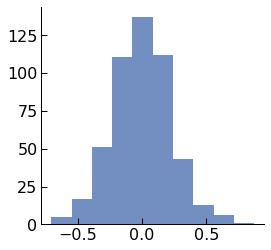

In [535]:
plt.hist(df_ctrl_sg.log2fold_diff_mean)

In [536]:
len((df_ctrl_sg.log2fold_diff_mean))

496

In [537]:
np.percentile(df_ctrl_sg.log2fold_diff_mean, 25) 

-0.14684341168262263

In [538]:
np.percentile(df_ctrl_sg.log2fold_diff_mean, 75) 

0.14776801562439792

In [539]:
df_ctrl_sg = df_ctrl_sg[df_ctrl_sg.log2fold_diff_mean > np.percentile(df_ctrl_sg.log2fold_diff_mean, 25)*0.85]
df_ctrl_sg = df_ctrl_sg[df_ctrl_sg.log2fold_diff_mean < np.percentile(df_ctrl_sg.log2fold_diff_mean, 75)*0.85]

In [540]:
len(df_ctrl_sg)

252

In [541]:
files = glob.glob('../../data/screen_summary/screen_log2fold_diffs_sgRNA_differentiation_all_20210826.csv')
df_diff_sg_ = pd.read_csv(files[0])
df_diff_sg_ = df_diff_sg_[df_diff_sg_.gene.str.contains('CONTROL')]

(array([ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  4.,  0.,  3.,  4.,  6.,  5.,
         1., 13., 12., 12., 11., 17., 23., 24., 17., 19., 19., 23., 32.,
        27., 19., 17., 27., 14., 26., 15., 20., 14., 17.,  5.,  8.,  6.,
         3.,  5.,  7.,  6.,  3.,  2.,  0.,  2.,  0.,  0.,  2.]),
 array([-0.26953148, -0.25755701, -0.24558254, -0.23360807, -0.2216336 ,
        -0.20965913, -0.19768466, -0.18571018, -0.17373571, -0.16176124,
        -0.14978677, -0.1378123 , -0.12583783, -0.11386336, -0.10188889,
        -0.08991442, -0.07793995, -0.06596547, -0.053991  , -0.04201653,
        -0.03004206, -0.01806759, -0.00609312,  0.00588135,  0.01785582,
         0.02983029,  0.04180477,  0.05377924,  0.06575371,  0.07772818,
         0.08970265,  0.10167712,  0.11365159,  0.12562606,  0.13760053,
         0.14957501,  0.16154948,  0.17352395,  0.18549842,  0.19747289,
         0.20944736,  0.22142183,  0.2333963 ,  0.24537077,  0.25734524,
         0.26931972,  0.28129419,  0.29326866,  0.30524313,

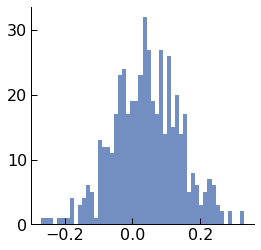

In [542]:
plt.hist(df_diff_sg_.log2fold_diff_mean, bins= 50)

In [543]:
df_diff_sg_ = df_diff_sg_[df_diff_sg_.sgRNA.isin(df_ctrl_sg.sgRNA)]

(array([ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  3.,  0.,  1.,  2.,  4.,  2.,
         0.,  4.,  7.,  7.,  7., 10., 12.,  8., 10.,  8., 14., 13., 18.,
        17., 10., 11., 10.,  8., 10.,  9.,  7.,  8.,  9.,  3.,  2.,  1.,
         0.,  1.,  5.,  2.,  1.,  1.,  0.,  1.,  0.,  0.,  2.]),
 array([-0.26953148, -0.25755701, -0.24558254, -0.23360807, -0.2216336 ,
        -0.20965913, -0.19768466, -0.18571018, -0.17373571, -0.16176124,
        -0.14978677, -0.1378123 , -0.12583783, -0.11386336, -0.10188889,
        -0.08991442, -0.07793995, -0.06596547, -0.053991  , -0.04201653,
        -0.03004206, -0.01806759, -0.00609312,  0.00588135,  0.01785582,
         0.02983029,  0.04180477,  0.05377924,  0.06575371,  0.07772818,
         0.08970265,  0.10167712,  0.11365159,  0.12562606,  0.13760053,
         0.14957501,  0.16154948,  0.17352395,  0.18549842,  0.19747289,
         0.20944736,  0.22142183,  0.2333963 ,  0.24537077,  0.25734524,
         0.26931972,  0.28129419,  0.29326866,  0.30524313,

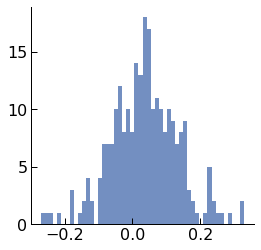

In [544]:
plt.hist(df_diff_sg_.log2fold_diff_mean, bins=50)

In [545]:
len(df_diff_sg_)

252

In [546]:
# df_diff_sg_

In [547]:
# overall the distribution  looks similar. I think this suggests that there is no major benefit to select
# the 250 sgRNA closest to zero based on the transwell data. But in anycase, I don't have a better way to 
# narrow down the  number of guides, so lets just use these (279 sgRNA), 

In [548]:
len('CAGCGCCAATGGGCTTTCGA' + 'CGTCTCACACCG' + 'AAAACATCGACCGAAAGCGT' + 'GTTTCGAGACG' + 'CGACAGGCTCTTAAGCGGCT')

83

# final libraries

The last thing I need to do is to add in the control sgRNAs into each of the three libraries

In [549]:
# Galvanotaxis; 
# AGGCACTTGCTCGTACGACG; ATGTGGGCCCGGCACCTTAA (rev complement: TTAAGGTGCCGGGCCCACAT) 
# 2660 sgRNA + 250 control sgRNA; 1079 genes 
# 'AGGCACTTGCTCGTACGACG' + 'CGTCTCACACCG' + 20bp sgRNA + 'GTTTCGAGACG' + 'TTAAGGTGCCGGGCCCACAT' \
# ECM; 
# GTGTAACCCGTAGGGCACCT; GTCGAGAGCAGTCCTTCGAC (rev complement: GTCGAAGGACTGCTCTCGAC) 
# 1287 sgRNA + 250 control sgRNA, 487 genes 
# 'GTGTAACCCGTAGGGCACCT' + 'CGTCTCACACCG' + 20bp sgRNA + 'GTTTCGAGACG' + 'GTCGAAGGACTGCTCTCGAC' \
# Differentiation; 
# CAGCGCCAATGGGCTTTCGA; AGCCGCTTAAGAGCCTGTCG (rev complement: CGACAGGCTCTTAAGCGGCT) 
# 1271 sgRNA + 250 control sgRNA, 614 genes 
# 'CAGCGCCAATGGGCTTTCGA' + 'CGTCTCACACCG' + 20bp sgRNA + 'GTTTCGAGACG' + 'CGACAGGCTCTTAAGCGGCT' \

df_galvo_rescreen_ = df_galvo_rescreen_.append(df_ctrl_sg, ignore_index = True)
df_ecm_rescreen_ = df_ecm_rescreen_.append(df_ctrl_sg, ignore_index = True)
df_diff_rescreen_ = df_diff_rescreen_.append(df_ctrl_sg, ignore_index = True)

In [550]:
df_galvo_rescreen_['full_seq'] = 'AGGCACTTGCTCGTACGACG' + 'CGTCTCACACCG' + df_galvo_rescreen_['sgRNA']  + 'GTTTCGAGACG' + 'TTAAGGTGCCGGGCCCACAT'

df_ecm_rescreen_['full_seq'] = 'GTGTAACCCGTAGGGCACCT' + 'CGTCTCACACCG' + df_ecm_rescreen_['sgRNA'] + 'GTTTCGAGACG' + 'GTCGAAGGACTGCTCTCGAC' \

df_diff_rescreen_['full_seq'] = 'CAGCGCCAATGGGCTTTCGA' + 'CGTCTCACACCG' + df_diff_rescreen_['sgRNA'] + 'GTTTCGAGACG' + 'CGACAGGCTCTTAAGCGGCT'


In [551]:
df_galvo_rescreen_['screen'] = 'galvanotaxis'
df_ecm_rescreen_['screen'] = 'ECM'
df_diff_rescreen_['screen'] = 'differentiation'


In [552]:
df_rescreen_combined = df_galvo_rescreen_.copy()
df_rescreen_combined = df_rescreen_combined.append(df_ecm_rescreen_, ignore_index = True)
df_rescreen_combined = df_rescreen_combined.append(df_diff_rescreen_, ignore_index = True)

In [553]:
df_rescreen_combined.head()

,gene,sgRNA,log2fold_diff_mean,Unnamed: 0,full_seq,screen
0,A1CF,CTCTGTGAAACTGTGTATTG,NaN,NaN,AGGCACTTGCTCGTACGACGCGTCTCACACCGCTCTGTGAAACTGT...,galvanotaxis
1,A1CF,GGGGATCTCTGAAATTACTC,NaN,NaN,AGGCACTTGCTCGTACGACGCGTCTCACACCGGGGGATCTCTGAAA...,galvanotaxis
2,A1CF,CGTTGAATTCGCCATAATCA,NaN,NaN,AGGCACTTGCTCGTACGACGCGTCTCACACCGCGTTGAATTCGCCA...,galvanotaxis
3,AARS,CCCTCAGAGTCCCCCGCCAA,NaN,NaN,AGGCACTTGCTCGTACGACGCGTCTCACACCGCCCTCAGAGTCCCC...,galvanotaxis
4,AARS,CCCTTGGCGGGGGACTCTGA,NaN,NaN,AGGCACTTGCTCGTACGACGCGTCTCACACCGCCCTTGGCGGGGGA...,galvanotaxis


I need to give each an ID number. Lets give a unique number to all sgRNA in the DataFrame.

In [554]:
dict_ID = dict(zip(df_rescreen_combined.sgRNA.unique(), 1+ np.arange(len(df_rescreen_combined.sgRNA.unique()))))

In [555]:
df_rescreen_combined['gene_ID'] = df_rescreen_combined['sgRNA'].values

df_rescreen_combined = df_rescreen_combined.replace({"gene_ID": dict_ID})

In [556]:
# df_rescreen_combined['geneName'] = df_rescreen_combined['gene'].values + '_' + str(df_rescreen_combined['gene_ID'].values)

In [557]:
df_rescreen_combined['geneName'] = df_rescreen_combined.agg('{0[gene]}_{0[gene_ID]}'.format, axis=1)

In [558]:
df_rescreen_combined.to_csv('../../data/rescreen_design/20211027_galvo_ecm_diff_alldetails.csv', index=False)

In [559]:
df_rescreen_combined_tocsv = df_rescreen_combined[['geneName', 'full_seq']]
df_rescreen_combined_tocsv.to_csv('../../data/rescreen_design/20211027_galvo_ecm_diff.csv', index=False)


In [560]:
df_rescreen_combined_tocsv.iloc[-5000].full_seq

'GTGTAACCCGTAGGGCACCTCGTCTCACACCGCACAGGCCCCCAGGACCCCTGTTTCGAGACGGTCGAAGGACTGCTCTCGAC'

In [561]:
len(df_rescreen_combined_tocsv)

9186

In [828]:
# if I include 3 sgRNA per gene
252*3 +  1079*3 + 487*3 + 614*3

7296

In [406]:
len(df_rescreen_combined_tocsv[df_rescreen_combined_tocsv.geneName.str.contains('CONTROL')])

756

In [416]:
df_rescreen_combined[df_rescreen_combined.gene == 'PIK3CG']

,gene,sgRNA,log2fold_diff_mean,Unnamed: 0,full_seq,screen,gene_ID,geneName
1993,PIK3CG,AATACCTGATAAAGCAGCGG,NaN,NaN,AGGCACTTGCTCGTACGACGCGTCTCACACCGAATACCTGATAAAG...,galvanotaxis,1994,PIK3CG_1994
1994,PIK3CG,GAAGAATTTAGACGCACACT,NaN,NaN,AGGCACTTGCTCGTACGACGCGTCTCACACCGGAAGAATTTAGACG...,galvanotaxis,1995,PIK3CG_1995
1995,PIK3CG,AATTTAGACGCACACTGGGT,NaN,NaN,AGGCACTTGCTCGTACGACGCGTCTCACACCGAATTTAGACGCACA...,galvanotaxis,1996,PIK3CG_1996
5422,PIK3CG,AATACCTGATAAAGCAGCGG,NaN,NaN,GTGTAACCCGTAGGGCACCTCGTCTCACACCGAATACCTGATAAAG...,ECM,1994,PIK3CG_1994
5423,PIK3CG,GAAGAATTTAGACGCACACT,NaN,NaN,GTGTAACCCGTAGGGCACCTCGTCTCACACCGGAAGAATTTAGACG...,ECM,1995,PIK3CG_1995
5424,PIK3CG,AGCAATACCTGATAAAGCAG,NaN,NaN,GTGTAACCCGTAGGGCACCTCGTCTCACACCGAGCAATACCTGATA...,ECM,5129,PIK3CG_5129


In [562]:
df_rescreen_combined[df_rescreen_combined.gene == 'APBB1IP']#.full_seq.values[0]

,gene,sgRNA,log2fold_diff_mean,Unnamed: 0,full_seq,screen,gene_ID,geneName
3577,APBB1IP,CCTTAGTCCCTCTTGCGTCG,NaN,NaN,GTGTAACCCGTAGGGCACCTCGTCTCACACCGCCTTAGTCCCTCTT...,ECM,3559,APBB1IP_3559
3578,APBB1IP,CTCGACGCAAGAGGGACTAA,NaN,NaN,GTGTAACCCGTAGGGCACCTCGTCTCACACCGCTCGACGCAAGAGG...,ECM,3560,APBB1IP_3560
3579,APBB1IP,CTTGCGTCGAGGCTGCAAAA,NaN,NaN,GTGTAACCCGTAGGGCACCTCGTCTCACACCGCTTGCGTCGAGGCT...,ECM,3561,APBB1IP_3561


In [563]:
df_ecm_sg[df_ecm_sg.gene == 'APBB1IP']

,Unnamed: 0,gene,sgRNA,log2fold_diff_mean
19557,19557,APBB1IP,CCTTAGTCCCTCTTGCGTCG,-1.589116
31486,31486,APBB1IP,GCAAAATGGTTCCATTCGCC,0.051401
56943,56943,APBB1IP,TTTGCAGCCTCGACGCAAGA,-0.142675


In [574]:
len(df_rescreen_combined[df_rescreen_combined.screen == 'galvanotaxis'])

3457

In [569]:
len(df_rescreen_combined[df_rescreen_combined.geneName.str.contains('CONTROL')])

756

In [573]:
1070*3+252

3462

## check some numbers for paper

In [6]:
df_temp = pd.read_csv('../../data/screen_libraries/20211027_galvo_ecm_diff_alldetails.csv')#, index=False)
df_temp = df_temp[df_temp.screen == 'galvanotaxis']

In [9]:
len(df_temp.gene.unique())

1070